## Project Statement

One of the major problem in the past decade in deep learning field was that of image classification, which is defined as
predicting the class of the image. A slightly complicated problem is that of image localization,
where the image contains a single object and the system should predict the class of the
location of the object in the image (a bounding box around the object). The more complicated
problem (this project), of object detection involves both classification and localization.
In this project, the input to the system will be a image, and the output will be a bounding box
corresponding to all the objects in the image, along with the class of object in each box.

In this project we use the YOLO model as pre-trained model. YOLO helps to classify 80 of different classes. YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

## Challenges
The major challenge for this project was to predict the bounding box (anchor) for the final image output. The bounding box is a rectangle drawn on the image which tightly fits the object in the image. A bounding box exists for every instance of every object in the image. For the box, 4 numbers (center x, center y, width, height) are predicted.

## Application
A well known application of object detection is face detection, that is used in almost all the mobile cameras. A more generalized (multi-class) application can be used in autonomous driving where a variety of objects need to be detected. Also it has a important role to play in surveillance systems. It can be used for tracking objects and thus can be used in robotics and medical applications. Thus this problem serves a multitude of applications.

## Importing all necessary libraries

In [0]:
import colorsys
import imghdr
import random
from keras import backend as K
from PIL import Image, ImageDraw, ImageFont
import argparse
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.utils.data_utils import GeneratorEnqueuer
import matplotlib.pyplot as plt
import math, os

%matplotlib inline

### Model fun() helps to process the input image and generates the results necessary for predicting the class present in each image

In [0]:
def model(output_matrix, box_detectors, categories, input1 = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    matrix = K.shape(output_matrix)[1:3]
    matrix_height = K.tile(K.arange(0, stop=matrix[0]), [matrix[1]])
    matrix_width = K.flatten(K.transpose(K.tile(K.expand_dims(K.arange(0, stop=matrix[1]), 0), [matrix[0], 1])))
    index = K.cast(K.reshape(K.transpose(K.stack([matrix_height, matrix_width])), [1, matrix[0], matrix[1], 1, 2]), K.dtype(output_matrix))
    output_matrix = K.reshape(output_matrix, [-1, matrix[0], matrix[1], len(box_detectors), categories + 5])
    matrix = K.cast(K.reshape(matrix, [1, 1, 1, 1, 2]), K.dtype(output_matrix))
    anchor_specs = K.exp(output_matrix[..., 2:4]) # anchors are the arrays used for object classification within there given area
    a = K.reshape(K.variable(box_detectors), [1, 1, 1, len(box_detectors), 2])
    anchor_specs = anchor_specs * a / matrix #height and width of anchor
    anchor_1 = (K.sigmoid(output_matrix[..., :2]) + index) / matrix - (anchor_specs / 2.)
    anchor_2 = (K.sigmoid(output_matrix[..., :2]) + index) / matrix + (anchor_specs / 2.)
    anchor = K.concatenate([anchor_1[..., 1:2], anchor_1[..., 0:1],anchor_2[..., 1:2],anchor_2[..., 0:1]]) #coordinates for anchor
    #Finding the probability of each class and filtering by only considering anchors with higher class probabilities
    class_probability1 = K.argmax(K.sigmoid(output_matrix[..., 4:5]) * K.softmax(output_matrix[..., 5:]), axis = -1)
    object_probability_1 = K.max(K.sigmoid(output_matrix[..., 4:5]) * K.softmax(output_matrix[..., 5:]),axis = -1)
    filtering_mask = (object_probability_1 >= score_threshold) # Considering only the anchors that have probabilities greater than score threshold
    object_probability = tf.boolean_mask(object_probability_1,filtering_mask)
    anchor = tf.boolean_mask(anchor,filtering_mask)
    class_probability = tf.boolean_mask(class_probability1,filtering_mask)
    #Adjusting the dimensions of anchor with reference to input image
    image_dims = K.reshape(K.stack([input1[0], input1[1], input1[0], input1[1]]), [1, 4])
    anchor = anchor * image_dims
    #Nonmax suppressing all the anchors to find the best optimal anchor
    anchor_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([anchor_tensor])) # initialize variable anchor_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nonmax_suprsn = tf.image.non_max_suppression(anchor, object_probability, max_boxes, iou_threshold)
   
    # Using K.gather() to select only nonmax suppressed properties
    object_probability = K.gather(object_probability, nonmax_suprsn)
    anchor = K.gather(anchor, nonmax_suprsn)
    class_probability = K.gather(class_probability, nonmax_suprsn)
    return object_probability, anchor, class_probability

### Predict func() draws the bounding box around the object classified from model func() and generates the end result

In [0]:
def predict(sess, image_file):
    
    image_type = imghdr.what(image_file)
    image = Image.open(image_file) #opens the image
    resized_image = image.resize(tuple(reversed((608, 608))), Image.BICUBIC) #resize the image according to required dimensions
    image_data = np.expand_dims(np.array(resized_image, dtype='float32') / 255, 0) 
    #generate the properties of final image
    obj_probability_output, anchor_final, class_prob_final = sess.run([object_probability, anchor, class_probability], feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})
    if len(anchor_final) == 0:
        return obj_probability_output, anchor_final, class_prob_final
    # Generate colors font and thickness for drawing anchor boxes
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), list(map(lambda x: colorsys.hsv_to_rgb(*x), [(x / len(class_names), 1., 1.) for x in range(len(class_names))]))))
    font = ImageFont.truetype("drive/My Drive/FiraMono-Medium.otf", size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300
    #box = anchor_final[i]
     
    #Drawing the anchor in final image
    for i, c in reversed(list(enumerate(class_prob_final))):
        top,left,bottom,right = anchor_final[i]
        label = '{} {:.2f}'.format(class_names[c], obj_probability_output[i])
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
    image.save("final_image.jpg", quality=90)
    output_image = scipy.misc.imread("final_image.jpg")
    plt.figure(figsize=(12,12))
    plt.imshow(plt.imread("final_image.jpg"))
    plt.show()
    

### Importing the contents from drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing the pre-trained YOLO model

In [0]:
from keras.models import load_model, Model
yolo_model = load_model("drive/My Drive/Colab Notebooks/yolo.h5")


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### YOLO model summary

In [0]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

### List of classes that can be predicted using this model

In [0]:
class_names = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
len(class_names)


80

In [0]:
input1 = (720., 1280.) #input image size

### Dimensions(weights) of Anchor used in model

In [0]:
box_detectors = [0.5,2,1,2,2,3,5,7,7,9]

In [0]:
box_detectors = np.array(box_detectors).reshape(-1, 2)
box_detectors  

array([[0.5, 2. ],
       [1. , 2. ],
       [2. , 3. ],
       [5. , 7. ],
       [7. , 9. ]])

### Using yolo_model.output to generate the model

In [0]:
model(yolo_model.output, box_detectors, len(class_names), input1)

(<tf.Tensor 'embedding_lookup_33/Identity:0' shape=(?,) dtype=float32>,
 <tf.Tensor 'embedding_lookup_34/Identity:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'embedding_lookup_35/Identity:0' shape=(?,) dtype=int64>)

In [0]:
sess = K.get_session() #starting a session

## Model Testing

### 1. Person

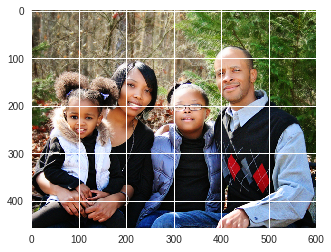

In [0]:
plt.imshow(plt.imread("drive/My Drive/Colab Notebooks/FreemanFamilyWeb.jpg"))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


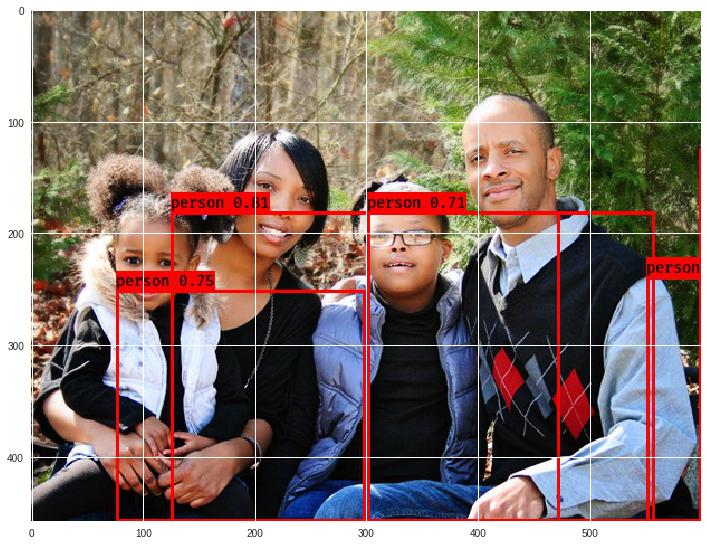

In [0]:
predict(sess,"drive/My Drive/Colab Notebooks/FreemanFamilyWeb.jpg")

### 2. Airplane

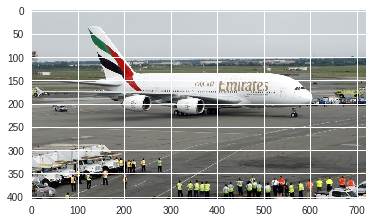

In [0]:
plt.imshow(plt.imread("drive/My Drive/Colab Notebooks/lead_720_405.jpg"))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


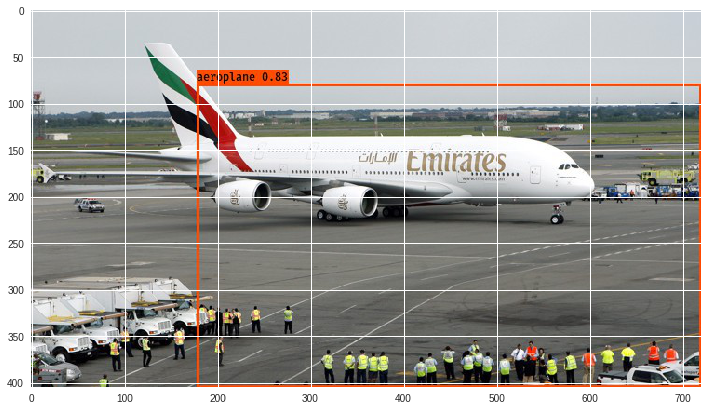

In [0]:
predict(sess,"drive/My Drive/Colab Notebooks/lead_720_405.jpg")

### 3. Cat

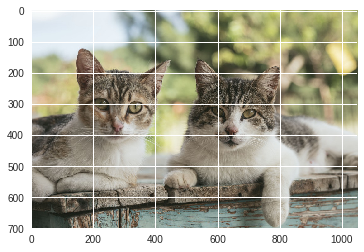

In [0]:
plt.imshow(plt.imread("drive/My Drive/Colab Notebooks/photo-1527416876370-fb74d128c3dc.jpg"))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


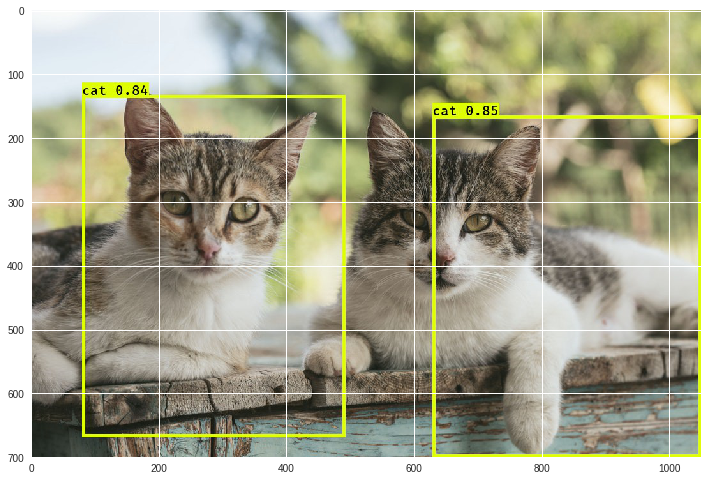

In [0]:
predict(sess, "drive/My Drive/Colab Notebooks/photo-1527416876370-fb74d128c3dc.jpg")

### 4. Car and Traffic Light

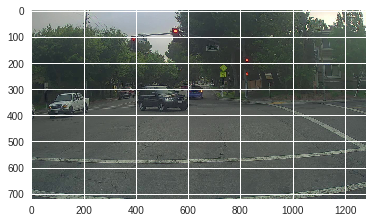

In [0]:
plt.imshow(plt.imread("drive/My Drive/Colab Notebooks/0082.jpg"))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


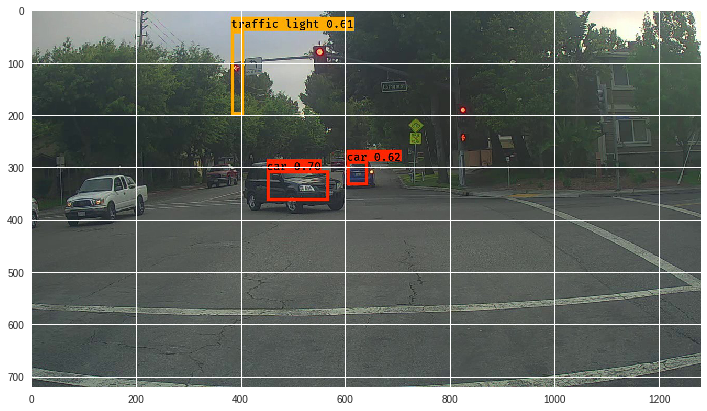

In [0]:
predict(sess,"drive/My Drive/Colab Notebooks/0082.jpg")

### 5 Laptop

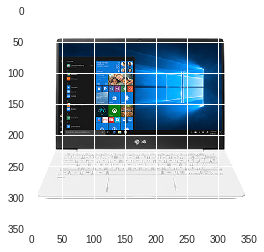

In [0]:
plt.imshow(plt.imread("drive/My Drive/Colab Notebooks/13Z980-U.AAW5U1-350x350.jpg"))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


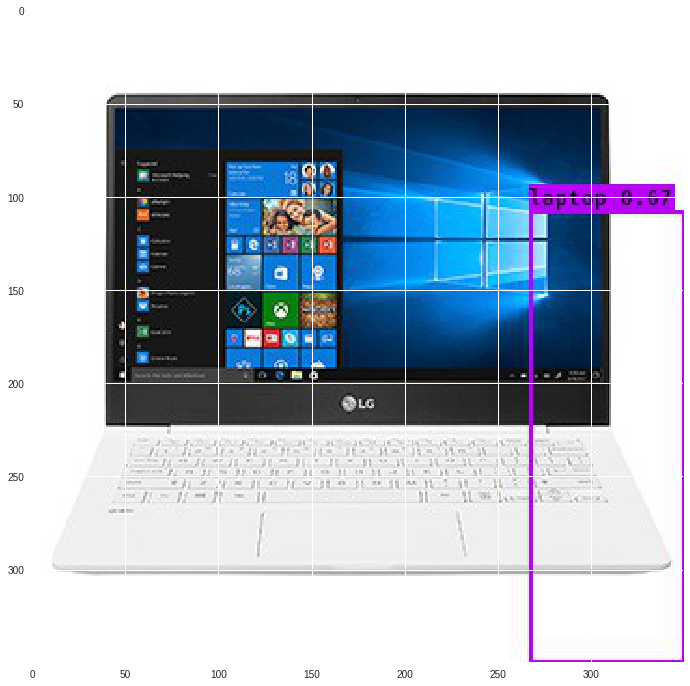

In [0]:
predict(sess,"drive/My Drive/Colab Notebooks/13Z980-U.AAW5U1-350x350.jpg")

## Object Detection (Wine Glass)

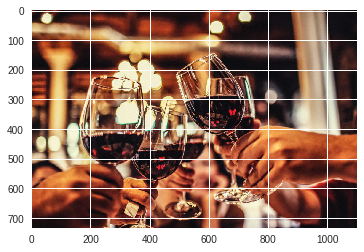

In [0]:
image_path = "drive/My Drive/Colab Notebooks/people-celebrating-with-wine-glasses.jpg"
plt.imshow(plt.imread(image_path))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


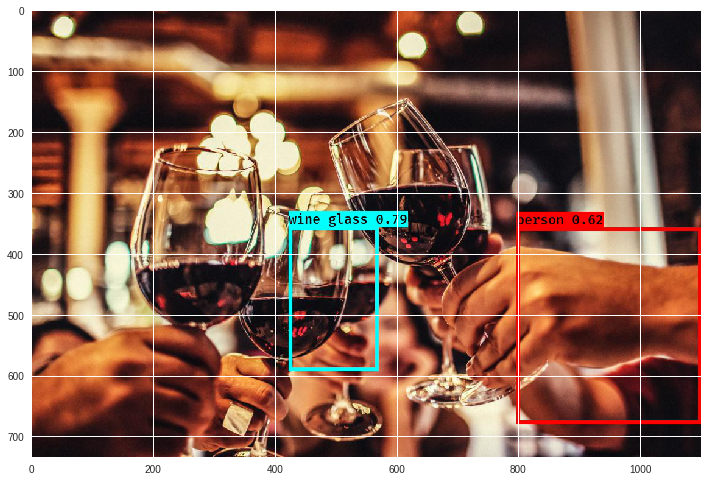

In [0]:
predict(sess,image_path)

### Object Detection
Enter the image file path of any image from your computer and run the code to see the result of this project.

In [0]:
image_path = None
plt.imshow(plt.imread(image_path))
plt.show()

In [0]:
predict(sess,image_path)